# Cornerplots

Checking the posteriors of jim and bilby runs just to make sure all seeds were OK.

## Preamble

In [14]:
import os
import copy
import numpy as np 
import json 
import matplotlib.pyplot as plt
import corner
import h5py

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

# Improved corner kwargs
default_corner_kwargs = dict(bins=40, 
                        smooth=1., 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        density = True,
                        truth_color = "black")

bilby_keys = ["chirp_mass",
              "mass_ratio",
              "chi_1",
              "chi_2",
              "luminosity_distance",
              "geocent_time",
              "phase",
              "theta_jn",
              "psi",
              "ra",
              "dec"
]

In [15]:
def my_report_runtime(time):
    hours = time // 3600
    minutes = (time % 3600) // 60
    seconds = time % 60
    return f"{hours:.0f}h {minutes:.0f}m {seconds:.0f}s"

## bilby plots

<Figure size 640x480 with 0 Axes>

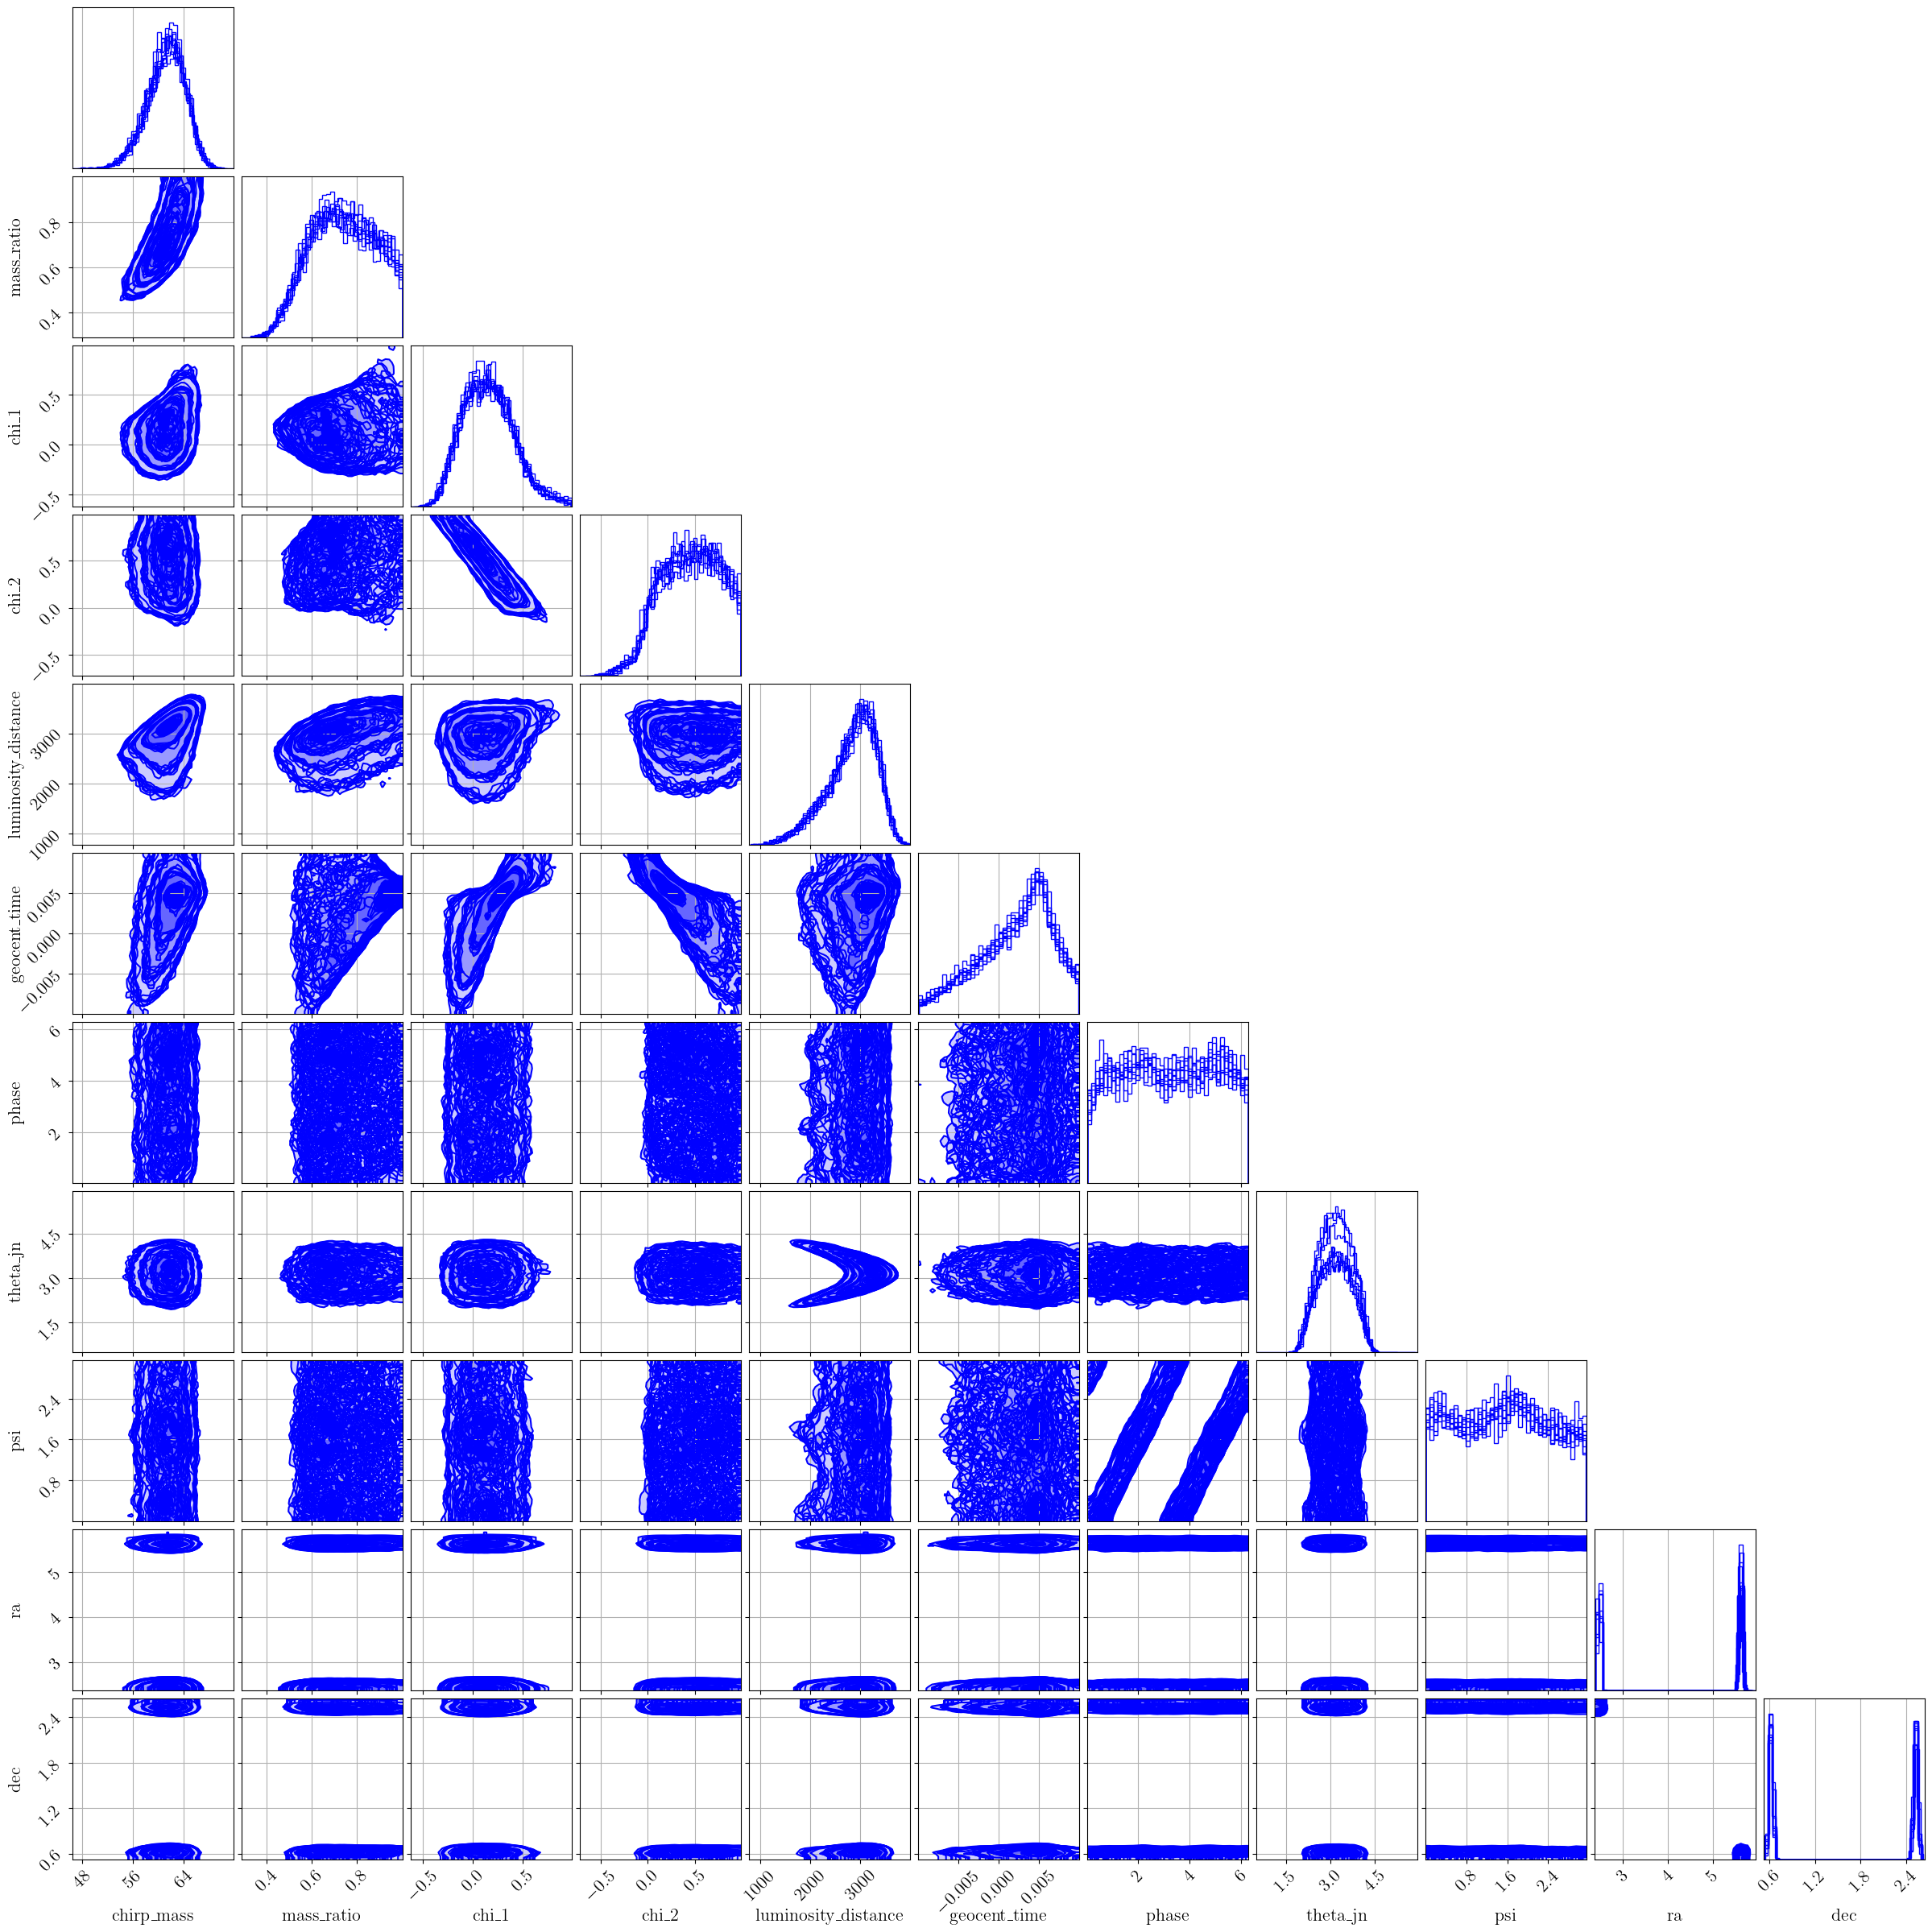

The average bilby sampling time was 7113.572459499696 seconds = 1h 58m 34s
The std bilby sampling time was 113.86413295222795 seconds = 0h 1m 54s


In [16]:
bilby_outdir = "./bilby/"
all_bilby_sampling_times = []

plt.figure()
for i in range(10):
    results_file = os.path.join(bilby_outdir, f"out_bbh_{i}/bbh_{i}_result.hdf5")
    with h5py.File(results_file, 'r') as f:
        bilby_posterior_dict = f["posterior"]
        bilby_posterior = np.array([bilby_posterior_dict[key] for key in bilby_keys]).T
        
        log_noise_evidence = f["log_noise_evidence"][()]
        log_evidence = f["log_evidence"][()]
        
        bilby_sampling_time = f["sampling_time"][()]
        all_bilby_sampling_times.append(bilby_sampling_time)
        
        if i == 0:
            fig = corner.corner(bilby_posterior, labels=bilby_keys, **default_corner_kwargs)
        else:
            corner.corner(bilby_posterior, fig=fig, **default_corner_kwargs)
plt.show()

print(f"The average bilby sampling time was {np.mean(all_bilby_sampling_times)} seconds = {my_report_runtime(np.mean(all_bilby_sampling_times))}")
print(f"The std bilby sampling time was {np.std(all_bilby_sampling_times)} seconds = {my_report_runtime(np.std(all_bilby_sampling_times))}")

## Jim

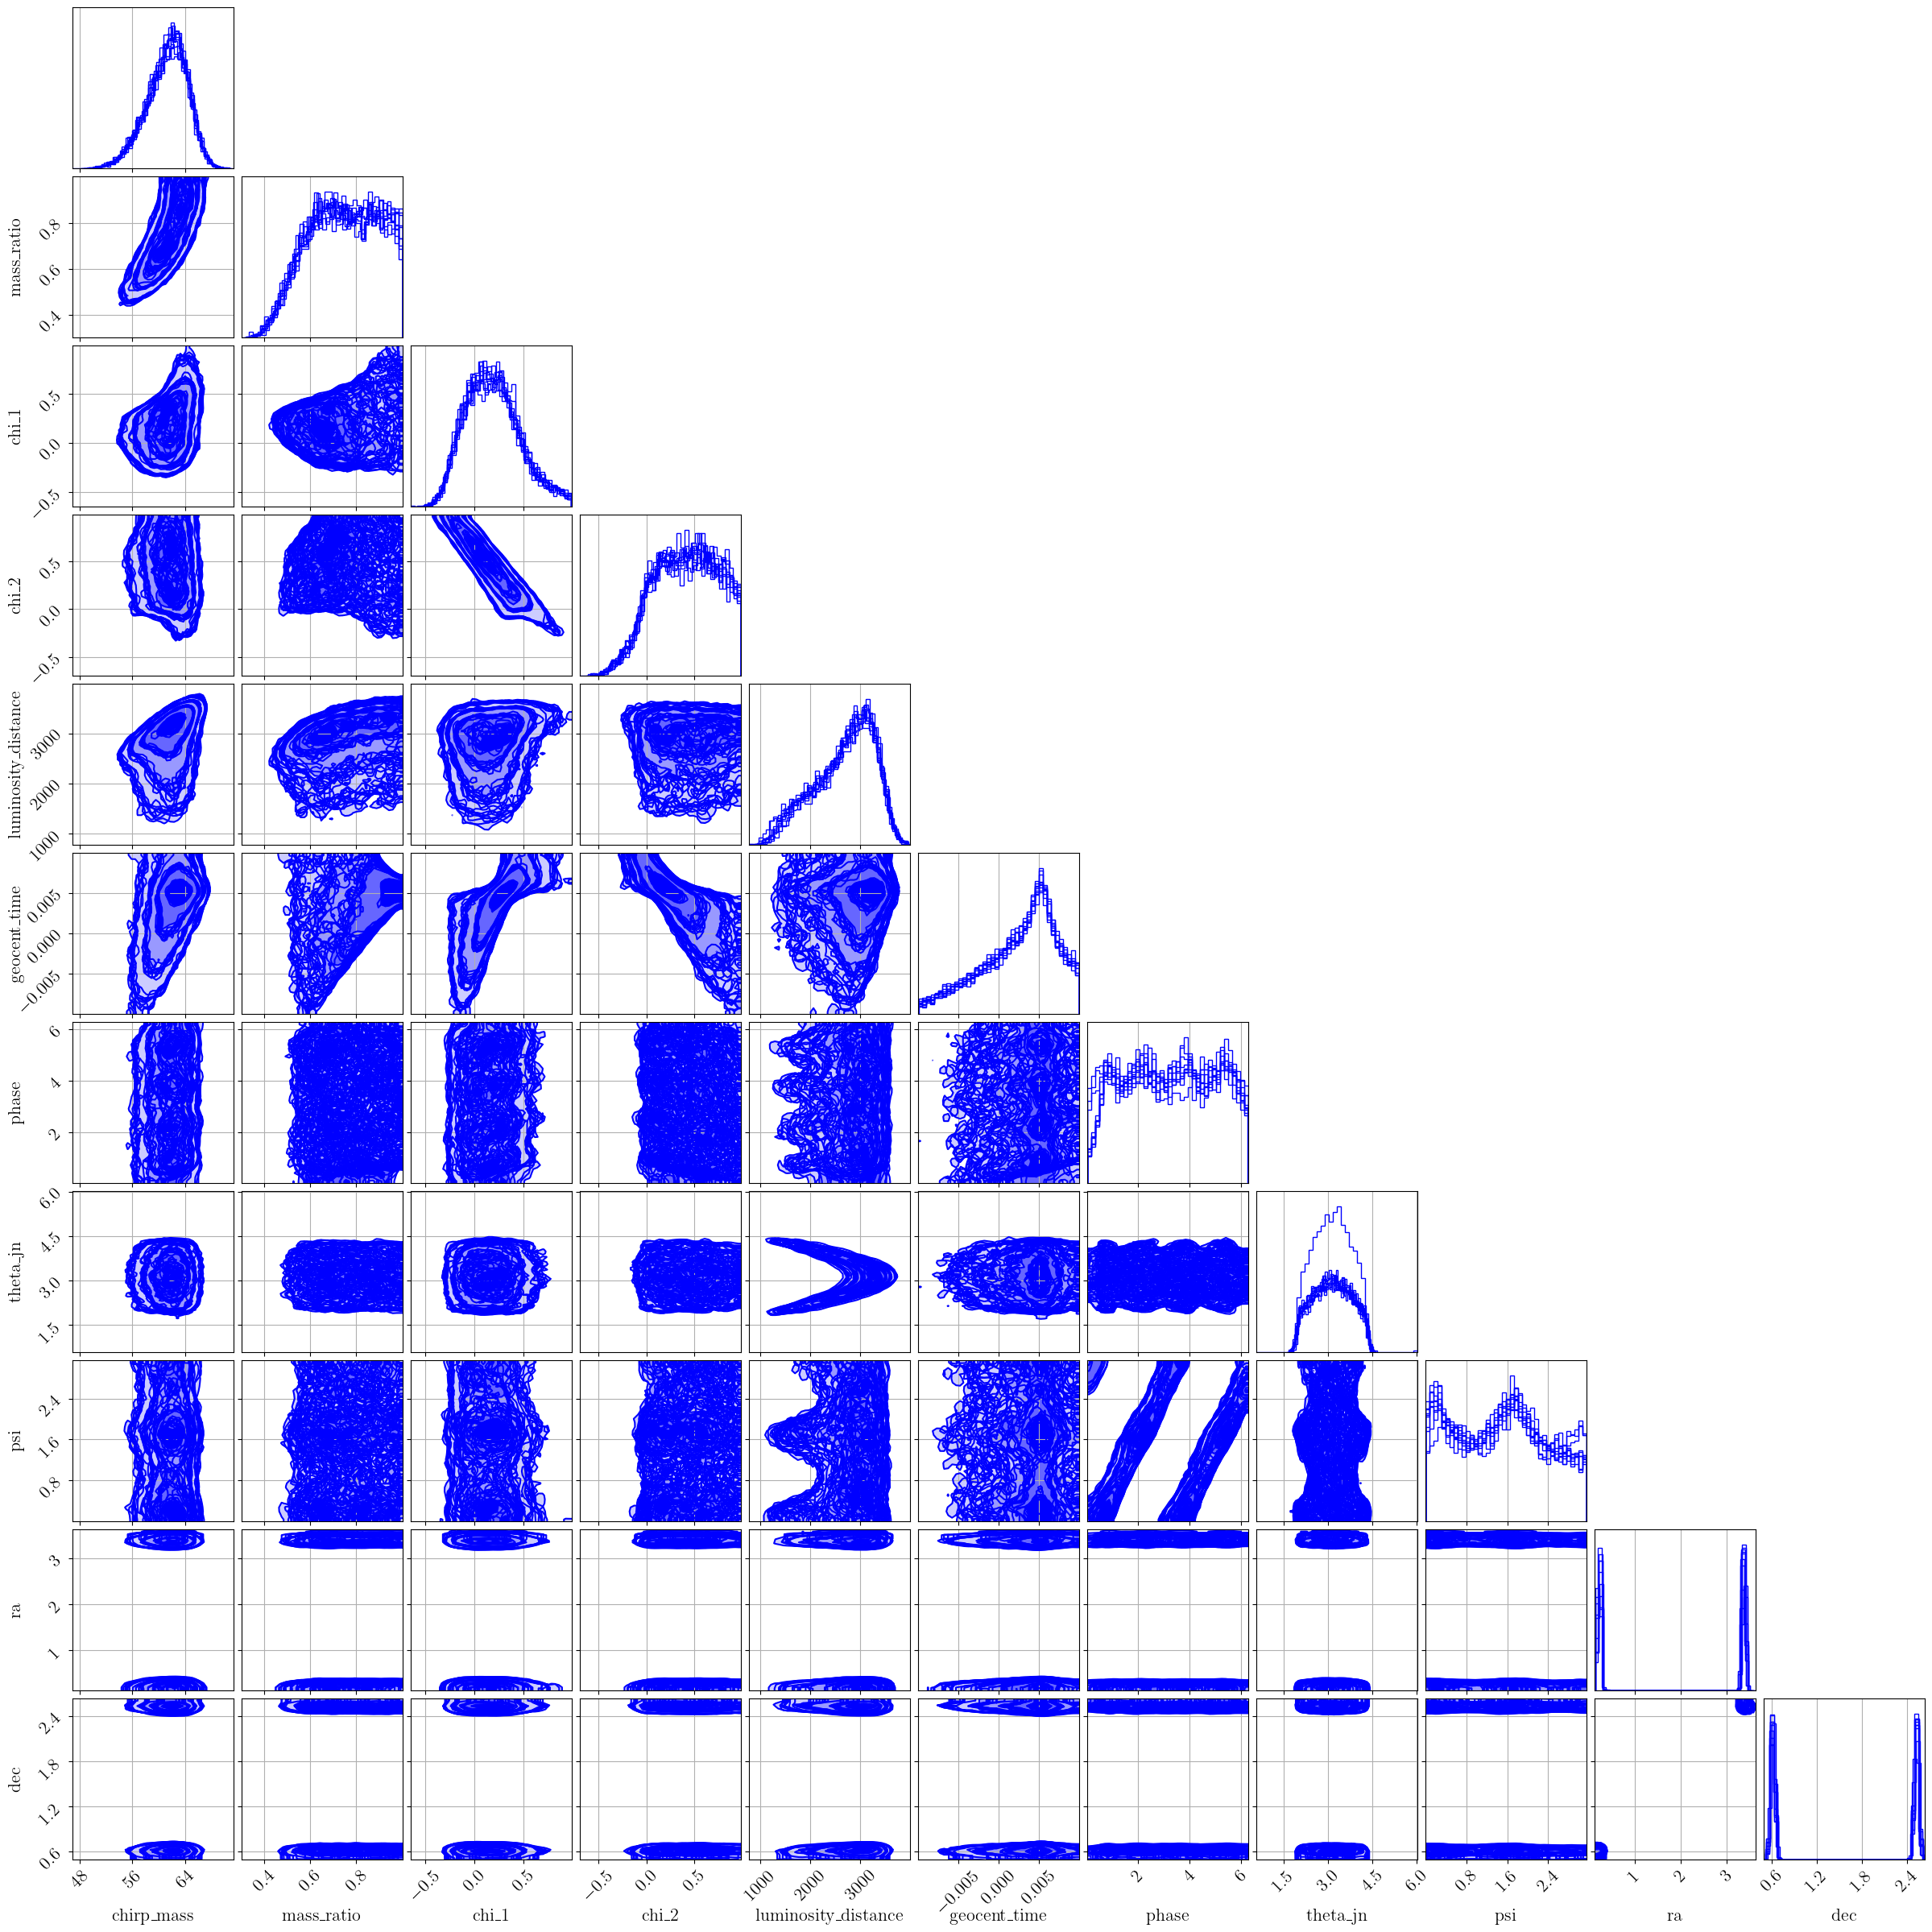

The average jim sampling time was 653.556316280365 seconds = 0h 10m 54s
The std jim sampling time was 40.731425430125846 seconds = 0h 0m 41s
The average speedup was 11.56


In [17]:
all_jim_sampling_times = []
all_log_prob = []

plt.figure()
for i in range(10):
    # Fetch the posteriors
    jim_outdir = f"./jim/injection_from_bilby_seed_{i}/"
    jim_file = os.path.join(jim_outdir, "results_production.npz")
    jim_posterior = np.load(jim_file)["chains"]
    jim_posterior = np.reshape(jim_posterior, (-1, jim_posterior.shape[-1]))

    # Report runtime
    jim_runtime_file = os.path.join(jim_outdir, 'runtime.txt')
    jim_sampling_time = np.loadtxt(jim_runtime_file)
    all_jim_sampling_times.append(jim_sampling_time)

    # Thinning the jim samples a bit to make it easier for corner to handle
    jump = 30
    jim_posterior = jim_posterior[::jump, :]
    
    if i == 0:
        fig = corner.corner(jim_posterior, labels=bilby_keys, **default_corner_kwargs)
    else:
        corner.corner(jim_posterior, fig=fig, **default_corner_kwargs)

plt.show()

print(f"The average jim sampling time was {np.mean(all_jim_sampling_times)} seconds = {my_report_runtime(np.mean(all_jim_sampling_times))}")
print(f"The std jim sampling time was {np.std(all_jim_sampling_times)} seconds = {my_report_runtime(np.std(all_jim_sampling_times))}")

speedup = np.mean(bilby_sampling_time) / np.mean(jim_sampling_time)
print(f"The average speedup was {speedup:.2f}")